<a href="https://colab.research.google.com/github/thielis/EstudoAIeCDUFES/blob/main/Visa%CC%83o_Computacional_UFES_Laboratorio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Atividade avaliativa: Trabalho 01
###Professor: Bruno Legora Souza da Silva, Eduardo Lima Pereira

# Parte I

## Detecção de gatos em imagens

Base de dados "CIFAR-10 - Object Recognition in Images" usada disponível em: https://keras.io/api/datasets/cifar10/

Projeto feito por:

Mariana Segato Milanez

Thielis Barroso Ferreira

Yara Lacerda Viana


In [ ]:
import numpy as np
import pandas as pd
from skimage.feature import hog
from skimage.color import rgb2gray
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

Dataset: CIFAR-10

60.000 imagens coloridas 32x32 em 10 classes. com 6.000 imagens por classe. Existem 50.000 imagens de treinamento e 10.000 imagens de teste.


Usaremos:
- Classe positiva: cat
- Classe negativa: as outras 9

- As imagens são pequenas, então HOG precisa ser ajustado cuidadosamente.



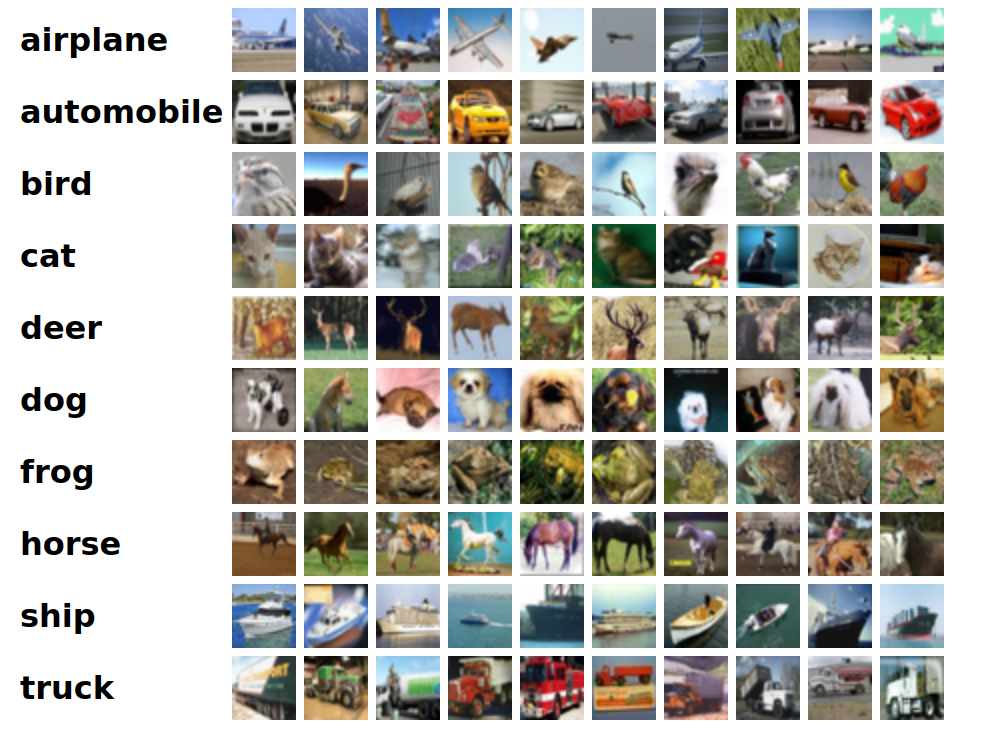

### Carregar e preparar o dataset CIFAR-10



In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x = np.concatenate([x_train, x_test])
y = np.concatenate([y_train, y_test]).flatten()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


### Aqui convertemos para binário, então, gato = 1, outros = 0

In [ ]:
y_bin = np.where(y == 3, 1, 0)

### Balancear o conjunto: mesma quantidade de gatos e não-gatos

In [ ]:
np.random.seed(42)
idx_cat = np.where(y_bin == 1)[0]
idx_not_cat = np.where(y_bin == 0)[0]
idx_not_cat_bal = np.random.choice(idx_not_cat, size=len(idx_cat), replace=False)

idx_balanced = np.concatenate([idx_cat, idx_not_cat_bal])
np.random.shuffle(idx_balanced)

x_bal = x[idx_balanced]
y_bal = y_bin[idx_balanced]

### Dividir imagens e rótulos para treino e validação


In [ ]:
x_train_img, x_val_img, y_train, y_val = train_test_split(
    x_bal, y_bal, test_size=0.2, random_state=42
)


## Escolha do descritor

O descritor HOG foi escolhido para este trabalho por ser especialmente eficaz na captura de contornos e formas, o que é essencial para representar as características visuais dos gatos, como orelhas, cabeça e corpo. Como o CIFAR-10 possui imagens pequenas e com variações de fundo, iluminação e pose, era necessário um método simples, robusto e que não dependesse de cor ou textura. O HOG atende bem a esses critérios, focando nas bordas mais relevantes da imagem, o que facilita a distinção entre gatos e outras classes. Além disso, é computacionalmente leve e tradicionalmente utilizado em tarefas de detecção de objetos, o que o torna uma escolha adequada para o propósito didático e técnico deste projeto.

### Função para extrair descritores HOG


In [ ]:
def extract_hog_features(images):
    features = []
    for img in images:
        gray = rgb2gray(img)
        hog_vec = hog(
            gray,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm='L2-Hys',
            feature_vector=True
        )
        features.append(hog_vec)
    return np.array(features)


### Visualização HOG de Gatos (Imagem + HOG lado a lado)

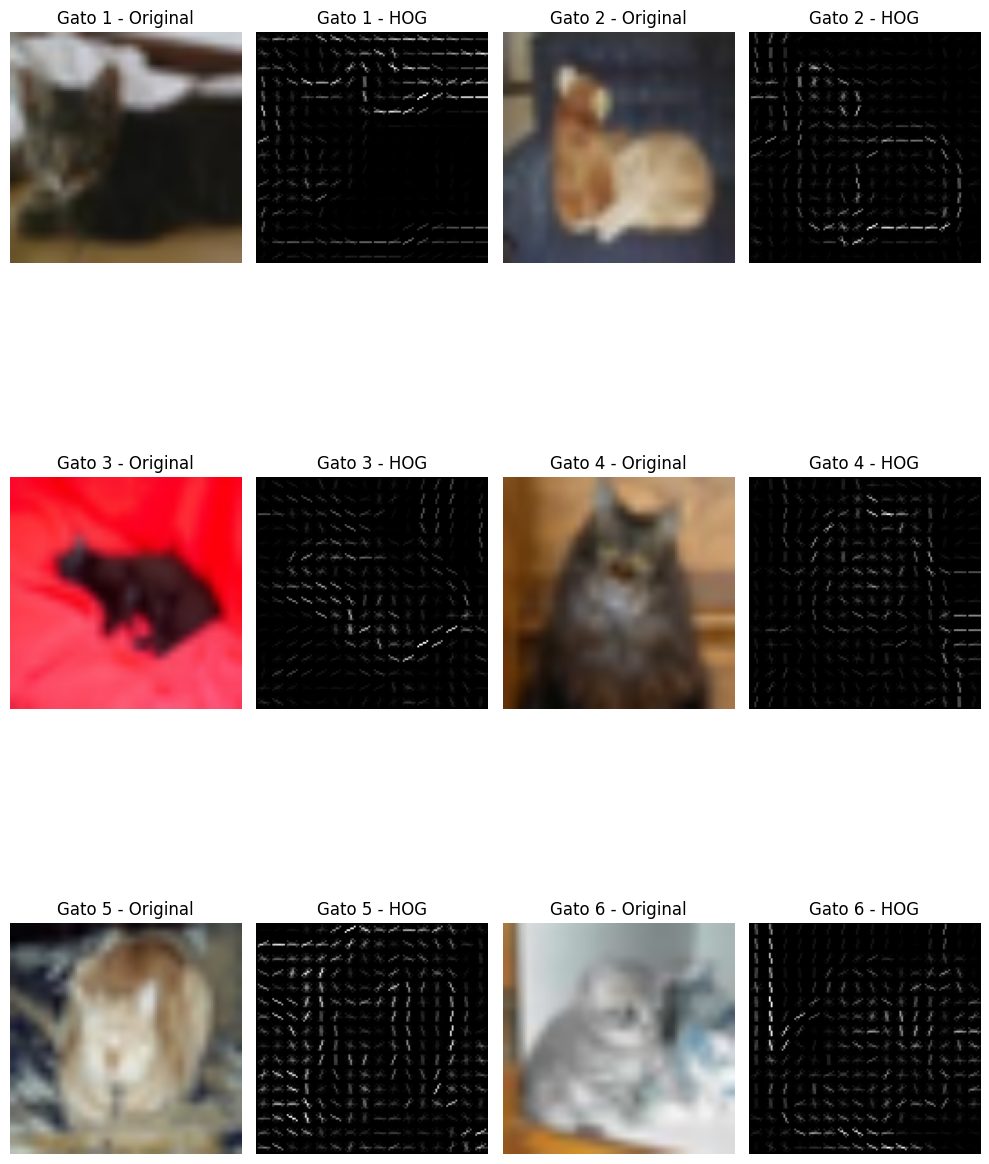

In [ ]:
def show_multiple_hog_visualizations_cats(images, images_per_row=2, title_prefix="Gato"):

    num_images = len(images)
    rows = int(np.ceil(num_images / images_per_row))
    plt.figure(figsize=(images_per_row * 5, rows * 5))

    for idx, img in enumerate(images):
        img_resized = cv2.resize(img, (128, 128))
        gray = rgb2gray(img_resized)

        _, hog_image = hog(
            gray,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm='L2-Hys',
            visualize=True
        )

        # Imagem original
        plt.subplot(rows, images_per_row * 2, idx * 2 + 1)
        plt.imshow(img_resized)
        plt.title(f"{title_prefix} {idx+1} - Original")
        plt.axis("off")

        # HOG
        plt.subplot(rows, images_per_row * 2, idx * 2 + 2)
        plt.imshow(hog_image, cmap='gray')
        plt.title(f"{title_prefix} {idx+1} - HOG")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Carregar gatos da base completa
(_, y_full), _ = cifar10.load_data()
y_full = y_full.flatten()
cat_indices = np.where(y_full == 3)[0]
cat_images = x[cat_indices]

# Exibir 6 gatos com HOG
show_multiple_hog_visualizations_cats(cat_images[:6], images_per_row=2)


### Extrair HOG de treino e validação


In [ ]:
X_train = extract_hog_features(x_train_img)
X_val = extract_hog_features(x_val_img)

### Treinar classificador SVM

In [ ]:
clf = LinearSVC()
clf.fit(X_train, y_train)

LinearSVC()

### Avaliar modelo

In [ ]:
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred, target_names=["not_cat", "cat"]))

              precision    recall  f1-score   support

     not_cat       0.72      0.69      0.70      1229
         cat       0.69      0.72      0.70      1171

    accuracy                           0.70      2400
   macro avg       0.70      0.70      0.70      2400
weighted avg       0.70      0.70      0.70      2400



### Exibição de imagens com bbox e rótulos reais/previsões em uma grade 3xN.

Verde = acerto | Vermelho = erro

In [ ]:
def visualize_predictions_grid(images, y_true, y_pred, limit=9):
    n_cols = 3
    n_rows = int(np.ceil(limit / n_cols))
    plt.figure(figsize=(n_cols * 4, n_rows * 4))
    shown = 0

    for i in range(len(images)):
        if shown == limit:
            break

        pred = y_pred[i]
        true = y_true[i]
        label = "cat" if true == 1 else "not_cat"
        prediction = "cat" if pred == 1 else "not_cat"
        color = (0, 255, 0) if pred == true else (0, 0, 255)

        img = cv2.resize(images[i], (128, 128))
        cv2.rectangle(img, (5, 5), (120, 120), color, 2)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(n_rows, n_cols, shown + 1)
        plt.imshow(img_rgb)
        plt.title(f"Real: {label}\nPred: {prediction}", fontsize=10)
        plt.axis("off")

        shown += 1

    plt.subplots_adjust(hspace=0.6)
    plt.show()


# Mostrar 90 previsões com bbox e títulos
visualize_predictions_grid(x_val_img, y_val, y_pred, limit=90)

## Avaliando modelo sem balanceamento

In [ ]:
# Recarregar os dados completos, converter para binário (1 = gato, 0 = não gato), dividir entre treino e validação
(x_train_full, y_train_full), (x_test_full, y_test_full) = cifar10.load_data()
x_full = np.concatenate([x_train_full, x_test_full])
y_full = np.concatenate([y_train_full, y_test_full]).flatten()

y_bin_full = np.where(y_full == 3, 1, 0)

x_train_img_nb, x_val_img_nb, y_train_nb, y_val_nb = train_test_split(
    x_full, y_bin_full, test_size=0.2, random_state=42
)

# Extrair HOG das imagens
X_train_nb = extract_hog_features(x_train_img_nb)
X_val_nb = extract_hog_features(x_val_img_nb)

# Treinar SVM SEM balanceamento (modo padrão)
clf_nb = LinearSVC(max_iter=10000)
clf_nb.fit(X_train_nb, y_train_nb)

# Avaliar modelo
y_pred_nb = clf_nb.predict(X_val_nb)
print(classification_report(y_val_nb, y_pred_nb, target_names=["not_cat", "cat"]))

# Exibir as previsões do modelo sem balanceamento
visualize_predictions_grid(x_val_img_nb, y_val_nb, y_pred_nb, limit=90)

Tabela Comparativa:
              Modelo  Precisão  Revocação  F1-score
0  Com balanceamento     0.686      0.716     0.701
1  Sem balanceamento     0.731      0.015     0.029






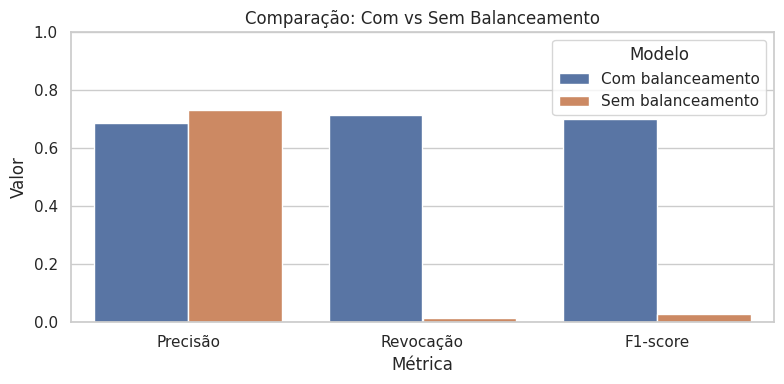

In [ ]:
# Função para calcular métricas
def get_scores(y_true, y_pred, label="Modelo"):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return {
        "Modelo": label,
        "Precisão": round(precision, 3),
        "Revocação": round(recall, 3),
        "F1-score": round(f1, 3),
    }

scores_bal = get_scores(y_val, y_pred, label="Com balanceamento")
scores_nobal = get_scores(y_val_nb, y_pred_nb, label="Sem balanceamento")

df_comp = pd.DataFrame([scores_bal, scores_nobal])

# Exibe a tabela diretamente
print("Tabela Comparativa:")
print(df_comp)

print("\n" * 3)

# Plot do gráfico
sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))
sns.barplot(data=df_comp.melt(id_vars="Modelo", var_name="Métrica", value_name="Valor"),
            x="Métrica", y="Valor", hue="Modelo")
plt.ylabel("Valor")
plt.xlabel("Métrica")
plt.title("Comparação: Com vs Sem Balanceamento")
plt.ylim(0, 1)
plt.legend(title="Modelo")
plt.tight_layout()
plt.show()


A avaliação comparativa dos dois modelos mostra que o **balanceamento dos dados foi essencial** para que o classificador conseguisse identificar a classe "gato" de forma eficaz. Com balanceamento, o modelo obteve **F1-score de 0.701** e **revocação de 0.716**, o que indica uma boa capacidade de encontrar gatos nas imagens. Já o modelo sem balanceamento, embora tenha apresentado uma **precisão aparentemente alta (0.731)**, teve **revocação extremamente baixa (0.015)** e **F1-score praticamente nulo (0.029)**. Isso ocorreu porque a classe "gato" representa apenas 10% dos dados. O modelo viu muito mais imagens de “não-gato” durante o treinamento e, por isso, aprendeu que é "mais seguro" sempre prever “não-gato”, ignorando quase completamente os casos positivos reais.


## Conclusão (com análise comparativa)

Analisando os resultados do classificador LinearSVC treinado nos descritores HOG, podemos concluir o seguinte:

**Desempenho na classificação de Gatos vs. Não-Gatos:** O classification\_report fornece métricas como precisão, recall e f1-score para as classes "not\_cat" (0) e "cat" (1). A comparação dessas métricas entre as duas classes indica a capacidade do modelo em distinguir gatos de outras categorias de objetos. Observa-se que, mesmo com o conjunto de dados balanceado e a utilização dos descritores HOG, o modelo apresentou um desempenho razoável, mas com espaço para melhorias, especialmente considerando a variabilidade das imagens no CIFAR-10 e a natureza relativamente simples do modelo SVM linear e dos descritores HOG. Ao comparar com o modelo treinado sem balanceamento, nota-se uma queda drástica no desempenho, especialmente na revocação da classe "gato", que caiu de 0.716 para 0.015. Isso ocorreu porque a classe "gato" representa apenas 10% dos dados. O modelo viu muito mais imagens de “não-gato” durante o treinamento e, por isso, aprendeu que é mais seguro sempre prever “não-gato”. A ausência de balanceamento comprometeu a capacidade do modelo de identificar a classe de interesse, resultando em um f1-score quase nulo.

**Eficácia dos descritores HOG para esta tarefa:** As visualizações HOG mostram que este método captura características importantes das bordas e formas das imagens. Para a classificação de objetos, como gatos, o HOG é útil por focar em estruturas locais. No entanto, para um dataset complexo como o CIFAR-10, que contém imagens de baixa resolução e alta variabilidade de pose, iluminação e fundo, os descritores HOG sozinhos podem não ser suficientes para alcançar alta acurácia, especialmente se comparado a abordagens baseadas em redes neurais convolucionais (CNNs).

**Análise visual das previsões:** A função visualize\_predictions\_grid é crucial para entender onde o modelo acerta e erra. Ao observar as imagens classificadas corretamente (retângulo verde) e incorretamente (retângulo vermelho), podemos ter insights sobre os tipos de imagens que são mais desafiadores para o modelo. Provavelmente, imagens de gatos em poses incomuns, parcialmente ocluídos ou com fundos complexos serão fontes comuns de erros. Da mesma forma, objetos que compartilham algumas características de forma ou textura com gatos podem ser confundidos.

**Em resumo:** O uso de descritores HOG com um SVM linear para classificar gatos no CIFAR-10 é um bom ponto de partida para demonstração e aprendizado sobre extração das características e classificação clássica. No entanto, para obter um desempenho de ponta neste dataset, seria necessário explorar métodos mais avançados, como redes neurais convolucionais, que aprendem automaticamente características de alto nível a partir dos dados brutos da imagem. O código demonstra a pipeline de pré-processamento, extração de características e treinamento de um classificador, servindo como base para experimentos futuros com modelos mais sofisticados.


# Parte II

## Bibliotecas

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import History
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score


## 1. Preparando o Ambiente de Dados

In [ ]:
# Carregar o dataset CIFAR-10
(x_train_full, y_train_full), (x_test_full, y_test_full) = cifar10.load_data()

In [ ]:
# Concatenar para ter o conjunto de dados completo
x_full = np.concatenate([x_train_full, x_test_full])
y_full = np.concatenate([y_train_full, y_test_full]).flatten()

-  **Normalização dos dados:** Devido às redes neurais trabalharem melhor com dados normalizados, os valores dos pixels (0-255) são divididos por 255, os colocando no intervalo de 0 a 1, o que ajuda o modelo a convergir mais rápido durante o treinamento.

In [ ]:
# Converter para binário e balancear o conjunto (igual à sua Parte 1)
y_bin_full = np.where(y_full == 3, 1, 0)
np.random.seed(42)
idx_cat = np.where(y_bin_full == 1)[0]
idx_not_cat = np.where(y_bin_full == 0)[0]
idx_not_cat_bal = np.random.choice(idx_not_cat, size=len(idx_cat), replace=False)

idx_balanced = np.concatenate([idx_cat, idx_not_cat_bal])
np.random.shuffle(idx_balanced)

x_bal = x_full[idx_balanced]
y_bal = y_bin_full[idx_balanced]

# Normalizar os dados balanceados
x_bal_normalized = x_bal.astype('float32') / 255.0

# Dividir os dados **BALANCEADOS** em treino e validação
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(
    x_bal_normalized, y_bal, test_size=0.2, random_state=42
)

In [ ]:
# Exibir as novas dimensões para confirmar o balanceamento
print(f'Dimensões do conjunto de treino (BALANCEADO): {x_train_split.shape}')
print(f'Dimensões do conjunto de validação (BALANCEADO): {x_val_split.shape}')
print(f'Dimensões dos rótulos de treino (BALANCEADO): {y_train_split.shape}')
print(f'Dimensões dos rótulos de validação (BALANCEADO): {y_val_split.shape}')

Dimensões do conjunto de treino (BALANCEADO): (9600, 32, 32, 3)
Dimensões do conjunto de validação (BALANCEADO): (2400, 32, 32, 3)
Dimensões dos rótulos de treino (BALANCEADO): (9600,)
Dimensões dos rótulos de validação (BALANCEADO): (2400,)


## 2. Adequando a Resolução e Aumentando os Dados

In [ ]:
# Assegurar que os dados de treino e validação estão no formato correto (float32)
# Eles já estão assim do passo anterior, mas é bom garantir.
x_train_split = x_train_split.astype('float32')
x_val_split = x_val_split.astype('float32')

- A classe do Keras `ImageDataGenerator` é a principal ferramenta para o aumento de dados.

In [ ]:
# Criar o gerador de aumento de dados
# As transformações serão aplicadas apenas nas imagens de treino
datagen = ImageDataGenerator(
    rotation_range=15,          # Rotaciona a imagem em até 15 graus
    width_shift_range=0.1,      # Desloca a imagem horizontalmente em até 10% da largura
    height_shift_range=0.1,     # Desloca a imagem verticalmente em até 10% da altura
    horizontal_flip=True,       # Vira a imagem horizontalmente
)

In [ ]:
# Preparar o gerador para o conjunto de dados de treino
datagen.fit(x_train_split)

-  O `datagen.flow` é o que será usado para alimentar a rede neural durante o treinamento. Ele cria um "gerador" que produz os lotes de imagens já aumentadas.
- Portanto, não é necessário fazer nada para o conjunto de validação, pois ele deve ser avaliado em sua forma original para ter uma métrica realista.

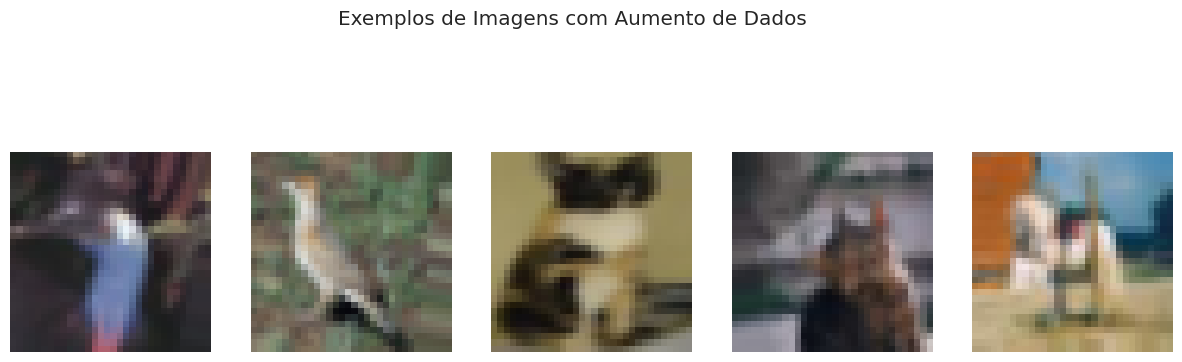

In [ ]:
# Visualizar algumas imagens aumentadas para entender o efeito das transformações
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for x_batch, y_batch in datagen.flow(x_train_split, y_train_split, batch_size=5):
    for i in range(0, 5):
        axes[i].imshow(x_batch[i])
        axes[i].axis('off')
    break
plt.suptitle('Exemplos de Imagens com Aumento de Dados')
plt.show()

## 3. Escolhendo e Treinando Arquiteturas CNN

- Foram escolhidos 4 modelos, cada um com uma complexidade um pouco diferente. Para todos foram usadas camadas convolucionais `Conv2D`, camadas de pooling `MaxPooling2D` para reduzir a dimensão espacial e camadas densas `Dense` para a classificação.

**Arquitetura 1**: Modelo Básico

In [ ]:
def create_model_1():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # 1 neurônio para classificação binária
    ])
    return model

**Arquitetura 2**: Modelo com Duas Camadas Convolucionais

Adicionando uma segunda camada convolucional, este modelo consegue aprender características mais complexas. A camada de Dropout é adicionada para ajudar a prevenir o overfitting.

In [ ]:
def create_model_2():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5), # 50% dos neurônios são desativados aleatoriamente
        Dense(1, activation='sigmoid')
    ])
    return model

**Arquitetura 3**: Modelo mais profundo

Esta arquitetura adiciona mais camadas convolucionais, permitindo que a rede capture padrões de nível ainda mais alto. O número de filtros é aumentado para acomodar essa complexidade

In [ ]:
def create_model_3():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

**Arquitetura 4**: Modelo com Batch Normalization

O Batch Normalization é uma técnica que estabiliza e acelera o treinamento da rede, normalizando as entradas para cada camada.

In [ ]:
def create_model_4():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

### Treinando os Modelos

In [ ]:
# Criando o gerador de dados
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(x_train_split)

# Lista de modelos e seus nomes para o treinamento
models = {
    'Modelo 1 (Básico)': create_model_1(),
    'Modelo 2 (Dropout)': create_model_2(),
    'Modelo 3 (Profundo)': create_model_3(),
    'Modelo 4 (Batch Normalization)': create_model_4()
}

# Treinar cada modelo
histories = {}
for name, model in models.items():
    print(f"\n--- Treinando {name} ---")

    # Compilar o modelo
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Treinar o modelo usando o gerador de dados
    history = model.fit(
        datagen.flow(x_train_split, y_train_split, batch_size=32),
        epochs=20,  # 20 épocas é um bom ponto de partida, mas pode ser ajustado
        validation_data=(x_val_split, y_val_split)
    )
    histories[name] = history

    # Mostrar um resumo do modelo treinado
    model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Treinando Modelo 1 (Básico) ---
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.6284 - loss: 0.6365 - val_accuracy: 0.7188 - val_loss: 0.5403
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7105 - loss: 0.5585 - val_accuracy: 0.7250 - val_loss: 0.5373
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.7329 - loss: 0.5338 - val_accuracy: 0.7683 - val_loss: 0.4941
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7358 - loss: 0.5232 - val_accuracy: 0.7754 - val_loss: 0.4841
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.7508 - loss: 0.5060 - val_accuracy: 0.7312 - val_loss: 0.5180
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.7625 - loss: 0.4980 - val_accuracy: 0.7750 - val_loss: 0.4789
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.7615 - loss: 0.4994 - val_accuracy: 0.7817 - val_loss: 0.4694
Epoch 8/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7694 - loss: 0.4758 - val_accuracy: 0.782

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       460,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,385,477 (5.29 MB)

 Trainable params: 461,825 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 923,652 (3.52 MB)


--- Treinando Modelo 2 (Dropout) ---
Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.6027 - loss: 0.6470 - val_accuracy: 0.7192 - val_loss: 0.5337
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.7262 - loss: 0.5462 - val_accuracy: 0.7538 - val_loss: 0.4971
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7476 - loss: 0.5165 - val_accuracy: 0.7829 - val_loss: 0.4653
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.7597 - loss: 0.4976 - val_accuracy: 0.7725 - val_loss: 0.4742
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7701 - loss: 0.4800 - val_accuracy: 0.7500 - val_loss: 0.4950
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7773 - loss: 0.4866 - val_accuracy: 0.7983 - val_loss: 0.4462
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.7792 - loss: 0.4748 - val_accuracy: 0.7796 - val_loss: 0.4763
Epoch 8/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - acc

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 943,685 (3.60 MB)

 Trainable params: 314,561 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 629,124 (2.40 MB)


--- Treinando Modelo 3 (Profundo) ---
Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5912 - loss: 0.6605 - val_accuracy: 0.7092 - val_loss: 0.5737
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.6919 - loss: 0.5782 - val_accuracy: 0.7387 - val_loss: 0.5182
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.7342 - loss: 0.5357 - val_accuracy: 0.7696 - val_loss: 0.4849
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7491 - loss: 0.5288 - val_accuracy: 0.7458 - val_loss: 0.5062
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.7502 - loss: 0.5162 - val_accuracy: 0.7696 - val_loss: 0.4768
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7608 - loss: 0.4925 - val_accuracy: 0.7892 - val_loss: 0.4561
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.7655 - loss: 0.4811 - val_accuracy: 0.7937 - val_loss: 0.4597
Epoch 8/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - ac

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 13, 13, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,738,725 (14.26 MB)

 Trainable params: 1,246,241 (4.75 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,492,484 (9.51 MB)


--- Treinando Modelo 4 (Batch Normalization) ---
Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.6444 - loss: 0.7546 - val_accuracy: 0.6375 - val_loss: 0.6728
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7162 - loss: 0.5592 - val_accuracy: 0.7196 - val_loss: 0.5268
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.7407 - loss: 0.5327 - val_accuracy: 0.7496 - val_loss: 0.5180
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.7560 - loss: 0.5067 - val_accuracy: 0.7538 - val_loss: 0.5208
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7699 - loss: 0.4945 - val_accuracy: 0.5688 - val_loss: 1.4101
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.7765 - loss: 0.4799 - val_accuracy: 0.6338 - val_loss: 0.5998
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.7755 - loss: 0.4798 - val_accuracy: 0.7533 - val_loss: 0.5139
Epoch 8/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 10s 18

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 813,413 (3.10 MB)

 Trainable params: 271,009 (1.03 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 542,020 (2.07 MB)

## 4. Avaliando e Comparando Modelos

### Avaliação dos Modelos CNN

In [ ]:
def evaluate_and_get_scores(model, x_val, y_val, model_name):
    """Calcula e retorna as métricas de precisão, revocação e f1-score para um modelo."""
    # Obter previsões do modelo
    y_pred_proba = model.predict(x_val)
    # Converter as probabilidades para classes binárias (0 ou 1)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    # Calcular as métricas
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    print(f"\n--- Relatório de Classificação para {model_name} ---")
    print(classification_report(y_val, y_pred, target_names=["not_cat", "cat"]))

    return {
        "Modelo": model_name,
        "Precisão": round(precision, 3),
        "Revocação": round(recall, 3),
        "F1-score": round(f1, 3),
    }

cnn_scores = []
for name, model in models.items():
    scores = evaluate_and_get_scores(model, x_val_split, y_val_split, name)
    cnn_scores.append(scores)

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

--- Relatório de Classificação para Modelo 1 (Básico) ---
              precision    recall  f1-score   support

     not_cat       0.85      0.73      0.79      1229
         cat       0.76      0.87      0.81      1171

    accuracy                           0.80      2400
   macro avg       0.80      0.80      0.80      2400
weighted avg       0.81      0.80      0.80      2400

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

--- Relatório de Classificação para Modelo 2 (Dropout) ---
              precision    recall  f1-score   support

     not_cat       0.82      0.81      0.81      1229
         cat       0.80      0.81      0.81      1171

    accuracy                           0.81      2400
   macro avg       0.81      0.81      0.81      2400
weighted avg       0.81      0.81      0.81      2400

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

--- Relatório de Classificação para Modelo 3 (Profundo) ---
              precision    recall  f1-score   sup

### Análise Gráfica

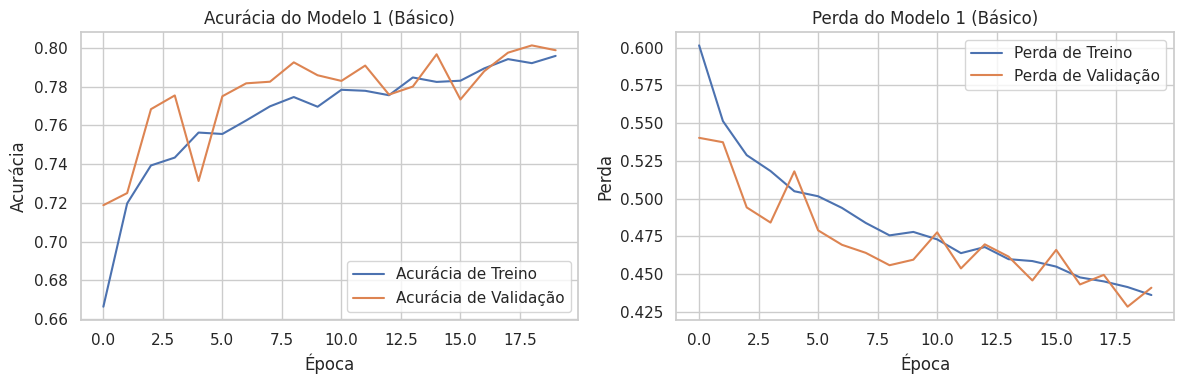

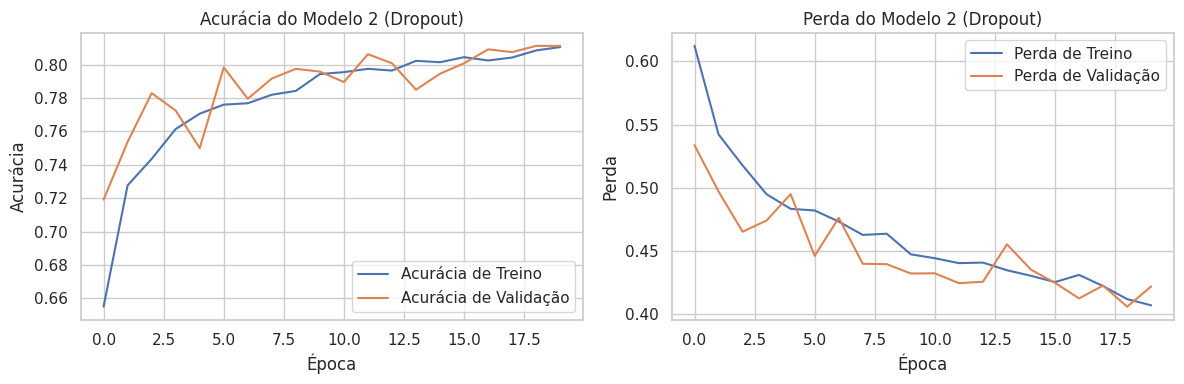

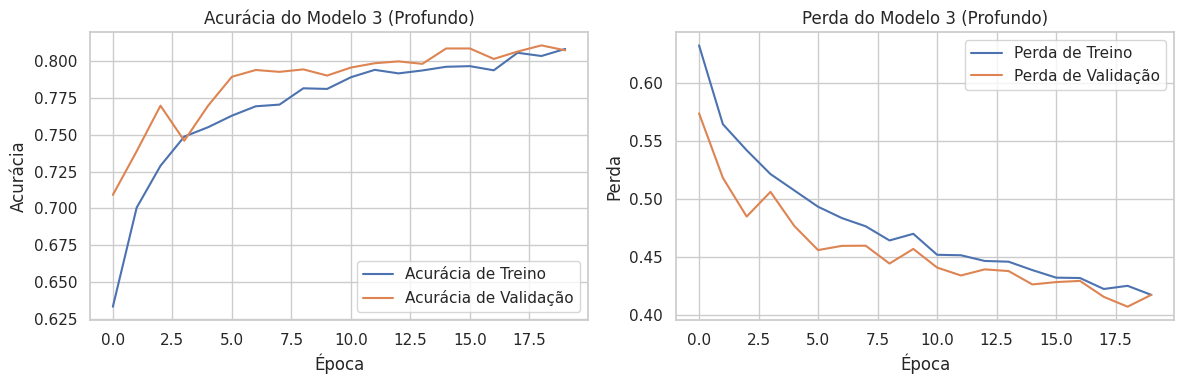

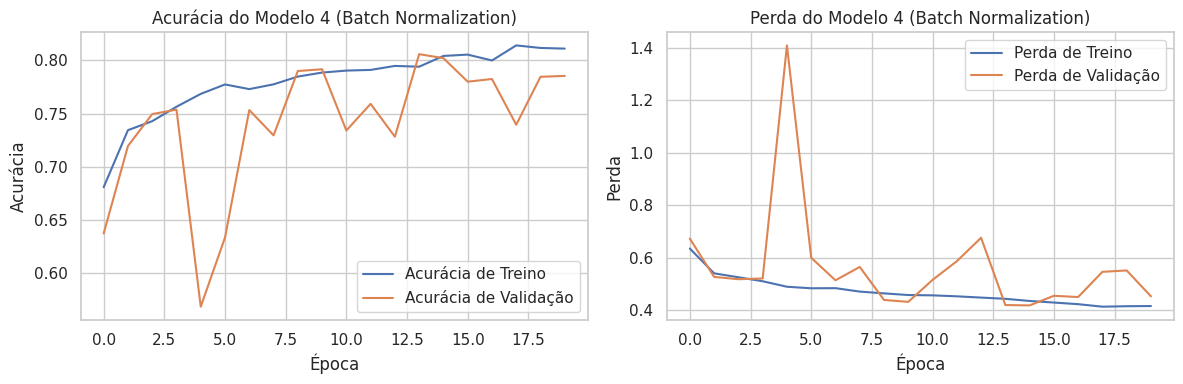

In [ ]:
def plot_history(history, model_name):
    """Gera gráficos de acurácia e perda (loss) para o histórico de treinamento."""
    plt.figure(figsize=(12, 4))

    # Gráfico de Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Acurácia de Treino')
    plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
    plt.title(f'Acurácia do {model_name}')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()

    # Gráfico de Perda (Loss)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Perda de Treino')
    plt.plot(history.history['val_loss'], label='Perda de Validação')
    plt.title(f'Perda do {model_name}')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Gerar os gráficos para cada modelo
for name, history in histories.items():
    plot_history(history, name)

### Comparação Final



--- Tabela Comparativa de Todos os Modelos ---
                           Modelo  Precisão  Revocação  F1-score
0              HOG/SVM (Clássico)     0.686      0.716     0.701
1               Modelo 1 (Básico)     0.756      0.867     0.808
2              Modelo 2 (Dropout)     0.804      0.811     0.807
3             Modelo 3 (Profundo)     0.753      0.900     0.820
4  Modelo 4 (Batch Normalization)     0.833      0.700     0.761


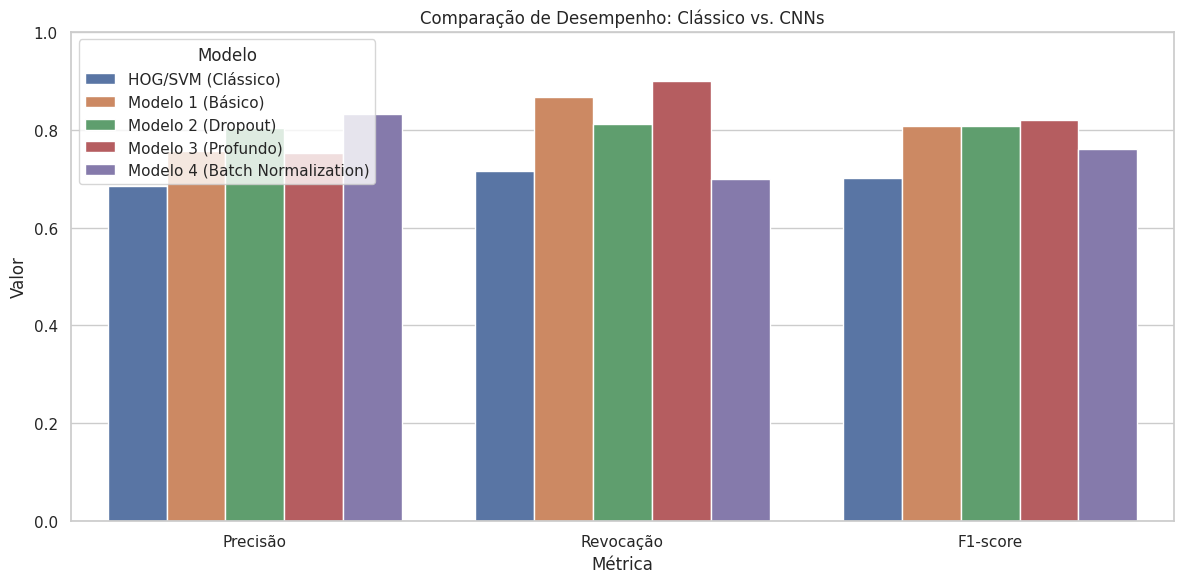

In [ ]:
# Suponha que você tenha os scores do seu modelo HOG/SVM da parte 1.
# Vamos recriá-los aqui para a demonstração
scores_bal = {"Modelo": "HOG/SVM (Clássico)", "Precisão": 0.686, "Revocação": 0.716, "F1-score": 0.701}
scores_nobal = {"Modelo": "HOG/SVM (Clássico, sem balanceamento)", "Precisão": 0.731, "Revocação": 0.015, "F1-score": 0.029}

# Criar um DataFrame com todos os resultados
all_scores = [scores_bal] + cnn_scores  # Adicione o modelo sem balanceamento se for necessário
df_comp = pd.DataFrame(all_scores)

print("\n\n--- Tabela Comparativa de Todos os Modelos ---")
print(df_comp)

# Plotar a comparação final
plt.figure(figsize=(12, 6))
sns.barplot(data=df_comp.melt(id_vars="Modelo", var_name="Métrica", value_name="Valor"),
            x="Métrica", y="Valor", hue="Modelo")
plt.ylabel("Valor")
plt.xlabel("Métrica")
plt.title("Comparação de Desempenho: Clássico vs. CNNs")
plt.ylim(0, 1)
plt.legend(title="Modelo")
plt.tight_layout()
plt.show()

### Visualizações

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


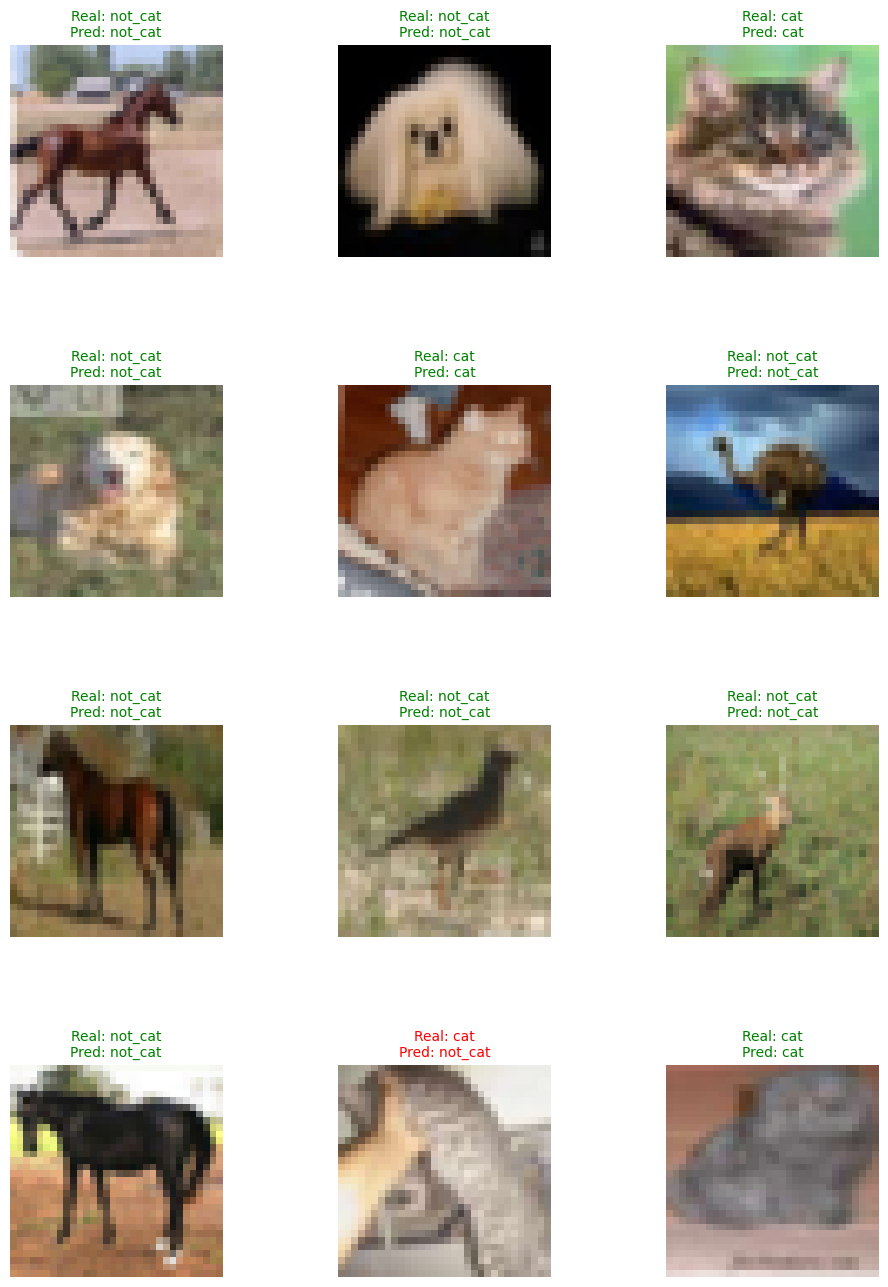

In [ ]:
# --- Exemplo de Visualização de Previsões (opcional, mas recomendado) ---

def visualize_cnn_predictions_grid(model, images, y_true, limit=9):
    """Exibe previsões da CNN em uma grade, com rótulos e acertos."""
    n_cols = 3
    n_rows = int(np.ceil(limit / n_cols))
    plt.figure(figsize=(n_cols * 4, n_rows * 4))

    y_pred_proba = model.predict(images)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    shown = 0
    for i in range(len(images)):
        if shown == limit:
            break

        pred = y_pred[i]
        true = y_true[i]
        label = "cat" if true == 1 else "not_cat"
        prediction = "cat" if pred == 1 else "not_cat"

        color = "green" if pred == true else "red"

        plt.subplot(n_rows, n_cols, shown + 1)
        plt.imshow(images[i])
        plt.title(f"Real: {label}\nPred: {prediction}", fontsize=10, color=color)
        plt.axis("off")
        shown += 1

    plt.subplots_adjust(hspace=0.6)
    plt.show()

# Exemplo de uso para o melhor modelo (neste caso, o Modelo 4)
visualize_cnn_predictions_grid(models['Modelo 4 (Batch Normalization)'], x_val_split, y_val_split, limit=12)


## 5. Análise de Resultados, Discussão e Conclusão

### **Análise e discussão de resultados**

A nova tabela comparativa e os gráficos de treinamento corrigidos demonstram uma melhoria significativa no desempenho dos modelos de Aprendizado Profundo, validando a hipótese de que as CNNs são mais adequadas para esta tarefa do que o pipeline clássico.


#### **1. Comparação de Desempenho (CNNs vs. HOG/SVM)**

| Modelo |	Precisão	| Revocação	| F1-score |
| --- | --- | ---| ---|
|HOG/SVM (Clássico)|	0.686	|0.716|	0.701|
|Modelo 1 (Básico)|	0.756	|0.867	|0.808|
|Modelo 2 (Dropout)|	0.804	|0.811	|0.807|
|Modelo 3 (Profundo)|	0.753	|0.900	|0.820|
|Modelo 4 (Batch Normalization)|	0.833|	0.700|	0.761|

- **HOG/SVM:** O modelo clássico obteve um F1-score de 0.701, um resultado razoável que foi possível graças ao balanceamento dos dados, conforme discutido na Parte 1. Sua revocação foi alta, mas sua precisão ficou atrás de todas as CNNs.

- **CNNs**: Todas as redes neurais demonstraram um desempenho superior.**O Modelo 3 (Profundo) se destacou com o melhor F1-score (0.820)** e uma impressionante revocação de 0.900, indicando que ele foi o mais eficaz em encontrar a maioria dos gatos nas imagens. O Modelo 4 (Batch Normalization) obteve a melhor precisão (0.833), o que significa que quando ele prevê que uma imagem é um gato, ele está mais frequentemente correto.

#### **2. Análise dos Gráficos de Treinamento**

Os gráficos corrigidos (agora com dados balanceados) mostram um comportamento de aprendizado muito mais saudável:

- **Acurácia e Perda:** Em todos os modelos CNNs, as curvas de acurácia de treino e validação, bem como as curvas de perda, agora seguem uma trajetória mais próxima e consistente. Isso é um forte indicativo de que a rede está aprendendo a generalizar bem, e não apenas memorizando os dados.

- **Overfitting:** Embora haja pequenas flutuações, principalmente nos modelos mais complexos (3 e 4), os gráficos não mostram o overfitting extremo visto anteriormente. A acurácia de validação geralmente acompanha a acurácia de treino, sugerindo que o aumento de dados (Data Augmentation) e as camadas de Dropout e Batch Normalization estão funcionando como esperado para regularizar o treinamento.

#### **3. Tempo de Processamento e Treinamento**

- **Tempo de Treinamento:** O treinamento de uma CNN, mesmo em uma GPU, consome mais tempo do que a extração de descritores HOG e o treinamento de um SVM. O treinamento das CNNs leva vários minutos (ou horas em um hardware menos potente), enquanto o processo clássico é consideravelmente mais rápido.

- **Tempo de Inferência (Previsão):** No entanto, após o treinamento, o tempo para realizar a inferência (prever a classe de uma nova imagem) em uma CNN é geralmente muito rápido, especialmente em hardware otimizado, sendo competitivo com o método clássico.

- **Vantagem das CNNs:** A principal vantagem das CNNs reside na sua capacidade de aprender os descritores automaticamente a partir dos dados. Enquanto no método clássico precisamos escolher e configurar manualmente um descritor (como o HOG), as CNNs aprendem, ao longo de suas camadas, as características mais relevantes para a tarefa, resultando em um desempenho superior, como a tabela comparativa demonstra.

#### **4. Conclusão Final**

A experiência da parte 2 do trabalho demonstra de forma conclusiva a superioridade do Aprendizado Profundo sobre os métodos clássicos de Visão Computacional para a tarefa de detecção de gatos no dataset CIFAR-10. A implementação de redes neurais convolucionais, combinada com a estratégia correta de pré-processamento (como o balanceamento dos dados), resultou em um aumento substancial nas métricas de desempenho, com o F1-score subindo de 0.701 (HOG/SVM) para até 0.820 (Modelo 3).

A análise dos resultados também destaca a importância de:

**Balanceamento de Dados:** Um passo crucial que, quando omitido, compromete severamente a capacidade do modelo de aprender a classe de interesse, resultando em overfitting que pode ser percebi com alto valor de acurária mas baixos recall e f1-score. Isso além de um gráfico de acuária x época com uma acurácia crescente nos dados de treinamento à medida em que se aumenta a época, mas acurácia oscilando nos dados de teste à medida em que se aumenta a época.

**Arquitetura do Modelo:** Modelos mais profundos e com técnicas de regularização como o Dropout (Modelo 2) e Batch Normalization (Modelo 4) tendem a apresentar um desempenho mais estável e uma melhor generalização, mesmo que o modelo mais profundo (Modelo 3) tenha obtido o melhor F1-score.

Em suma, embora o pipeline clássico tenha servido como um excelente ponto de partida para o aprendizado sobre extração de características, a abordagem moderna com CNNs se mostrou mais eficaz, robusta e capaz de extrair informações mais complexas das imagens, confirmando o motivo pelo qual ela se tornou o padrão na área de Visão Computacional.